# Author : Manas Mahale <<manas.mahale@bcp.edu.in>>
---
### [ResNet](https://arxiv.org/abs/1512.03385)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

import copy
from collections import namedtuple
import os
import random
import shutil
import time

### setting random seeds for reproducability.

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
BATCH_SIZE = 64
EPOCHS = 1
classes = ['Drug','Drug Like','Non Drug']

In [4]:
X_train = pd.read_pickle('./Data/processed/X_train.pkl').values
y_train = pd.read_pickle('./Data/processed/y_train.pkl').values
X_test  = pd.read_pickle('./Data/processed/X_test.pkl').values
y_test  = pd.read_pickle('./Data/processed/y_test.pkl').values

In [5]:
vocab = list(set(np.concatenate([list(i) for i in X_train])))
vocab_ = list(set(np.concatenate([list(i) for i in X_test])))
vocab.extend(vocab_)
vocab = list(set(vocab))

In [6]:
d = {}
for n, i in enumerate(vocab):
    zero = np.zeros(len(vocab))
    zero[n]=1
    d[i] = zero

In [7]:
def padded_one_hot_encode_smiles(smiles, pad_len = max(max([len(i) for i in X_train]),max([len(i) for i in X_test]))):
    return np.array([d[smiles[i]] if i < len(smiles) else np.zeros(len(vocab)) for i in range(pad_len)])

In [8]:
X_val   = np.array([padded_one_hot_encode_smiles(i) for i in X_train[20:50]]).astype(np.float32)
X_train = np.array([padded_one_hot_encode_smiles(i) for i in X_train[10:100]]).astype(np.float32)
X_test  = np.array([padded_one_hot_encode_smiles(i) for i in X_test[60:100]]).astype(np.float32)

In [9]:
y_test  = y_test[60:100]
y_train = y_train[10:100]
y_val   = y_train[20:50]

In [10]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test[i], y_test[i]])

val_data = []
for i in range(len(X_val)):
    val_data.append([X_val[i], y_val[i]])

In [11]:
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator  = data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(val_data, shuffle=False, batch_size=BATCH_SIZE)

In [12]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [13]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [14]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [15]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [16]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [17]:
# pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
# pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34')
pretrained_model = models.resnet50(pretrained = False)
# pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50')
# pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101')
# pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152')

In [18]:
OUTPUT_DIM = 3
conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
fc    = nn.Linear(in_features=2048, out_features=3, bias=True)

In [19]:
pretrained_model.fc = fc
pretrained_model.conv1 = conv1

In [20]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,507,907 trainable parameters


---
## Training Model

In [22]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [23]:
START_LR = 1e-7
optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = FocalLoss()

model = model.to(device)
criterion = criterion.to(device)

In [24]:
# class LRFinder:
#     def __init__(self, model, optimizer, criterion, device):
        
#         self.optimizer = optimizer
#         self.model = model
#         self.criterion = criterion
#         self.device = device
        
#         torch.save(model.state_dict(), 'init_params.pt')

#     def range_test(self, iterator, end_lr = 10, num_iter = 100, 
#                    smooth_f = 0.05, diverge_th = 5):
        
#         lrs = []
#         losses = []
#         best_loss = float('inf')

#         lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
#         iterator = IteratorWrapper(iterator)
        
#         for iteration in range(num_iter):

#             loss = self._train_batch(iterator)

#             #update lr
#             lr_scheduler.step()
            
#             lrs.append(lr_scheduler.get_lr()[0])

#             if iteration > 0:
#                 loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
#             if loss < best_loss:
#                 best_loss = loss

#             losses.append(loss)
            
#             if loss > diverge_th * best_loss:
#                 print("Stopping early, the loss has diverged")
#                 break
                       
#         #reset model to initial parameters
#         model.load_state_dict(torch.load('init_params.pt'))
                    
#         return lrs, losses

#     def _train_batch(self, iterator):
        
#         self.model.train()
        
#         self.optimizer.zero_grad()
        
#         x, y = iterator.get_batch()
        
#         x = x.to(self.device)
#         y = y.to(self.device)
        
#         y_pred, _ = self.model(x.unsqueeze(1))
                
#         loss = self.criterion(y_pred, y)
        
#         loss.backward()
        
#         self.optimizer.step()
        
#         return loss.item()

# class ExponentialLR(_LRScheduler):
#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(ExponentialLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

# class IteratorWrapper:
#     def __init__(self, iterator):
#         self.iterator = iterator
#         self._iterator = iter(iterator)

#     def __next__(self):
#         try:
#             inputs, labels = next(self._iterator)
#         except StopIteration:
#             self._iterator = iter(self.iterator)
#             inputs, labels, *_ = next(self._iterator)

#         return inputs, labels

#     def get_batch(self):
#         return next(self)

In [25]:
# END_LR = 10
# NUM_ITER = 100

# lr_finder = LRFinder(model, optimizer, criterion, device)
# lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

In [26]:
# def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
#     if skip_end == 0:
#         lrs = lrs[skip_start:]
#         losses = losses[skip_start:]
#     else:
#         lrs = lrs[skip_start:-skip_end]
#         losses = losses[skip_start:-skip_end]
    
#     fig = plt.figure(figsize = (16,8))
#     ax = fig.add_subplot(1,1,1)
#     ax.plot(lrs, losses)
#     ax.set_xscale('log')
#     ax.set_xlabel('Learning rate')
#     ax.set_ylabel('Loss')
#     ax.grid(True, 'both', 'x')
#     plt.show()

In [27]:
# plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [28]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters() , 'lr': FOUND_LR / 12},
          {'params': model.bn1.parameters()   , 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [29]:
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [30]:
def calculate_topk_accuracy(y_pred, y, k = 3):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [31]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator, ncols=1000, total = len(iterator)):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x.unsqueeze(1))
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss  /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [32]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in tqdm(iterator, ncols=1000, total = len(iterator)):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x.unsqueeze(1))

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
best_valid_loss = float('inf')

for epoch in trange(EPOCHS, leave=False):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './FOCAL_CHEM_RESNET.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc : {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc : {valid_acc_5*100:6.2f}%\n')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                         …

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|                                                                                                         …

Epoch: 01 | Epoch Time: 0m 58s

	Train Loss: 0.601 | Train Acc @1:  50.42% | Train Acc : 100.00%
	Valid Loss: 0.411 | Valid Acc @1:  50.00% | Valid Acc : 100.00%



In [35]:
model.load_state_dict(torch.load('./FOCAL_CHEM_RESNET.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc : {test_acc_5*100:6.2f}%')

  0%|                                                                                                         …

Test Loss: 0.383 | Test Acc @1:  60.00% | Test Acc : 100.00%


---
## Examining the Model

In [36]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x.unsqueeze(1))

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [37]:
images, labels, probs = get_predictions(model, test_iterator)

In [38]:
pred_labels = torch.argmax(probs, 1)

In [39]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(dpi=300);
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

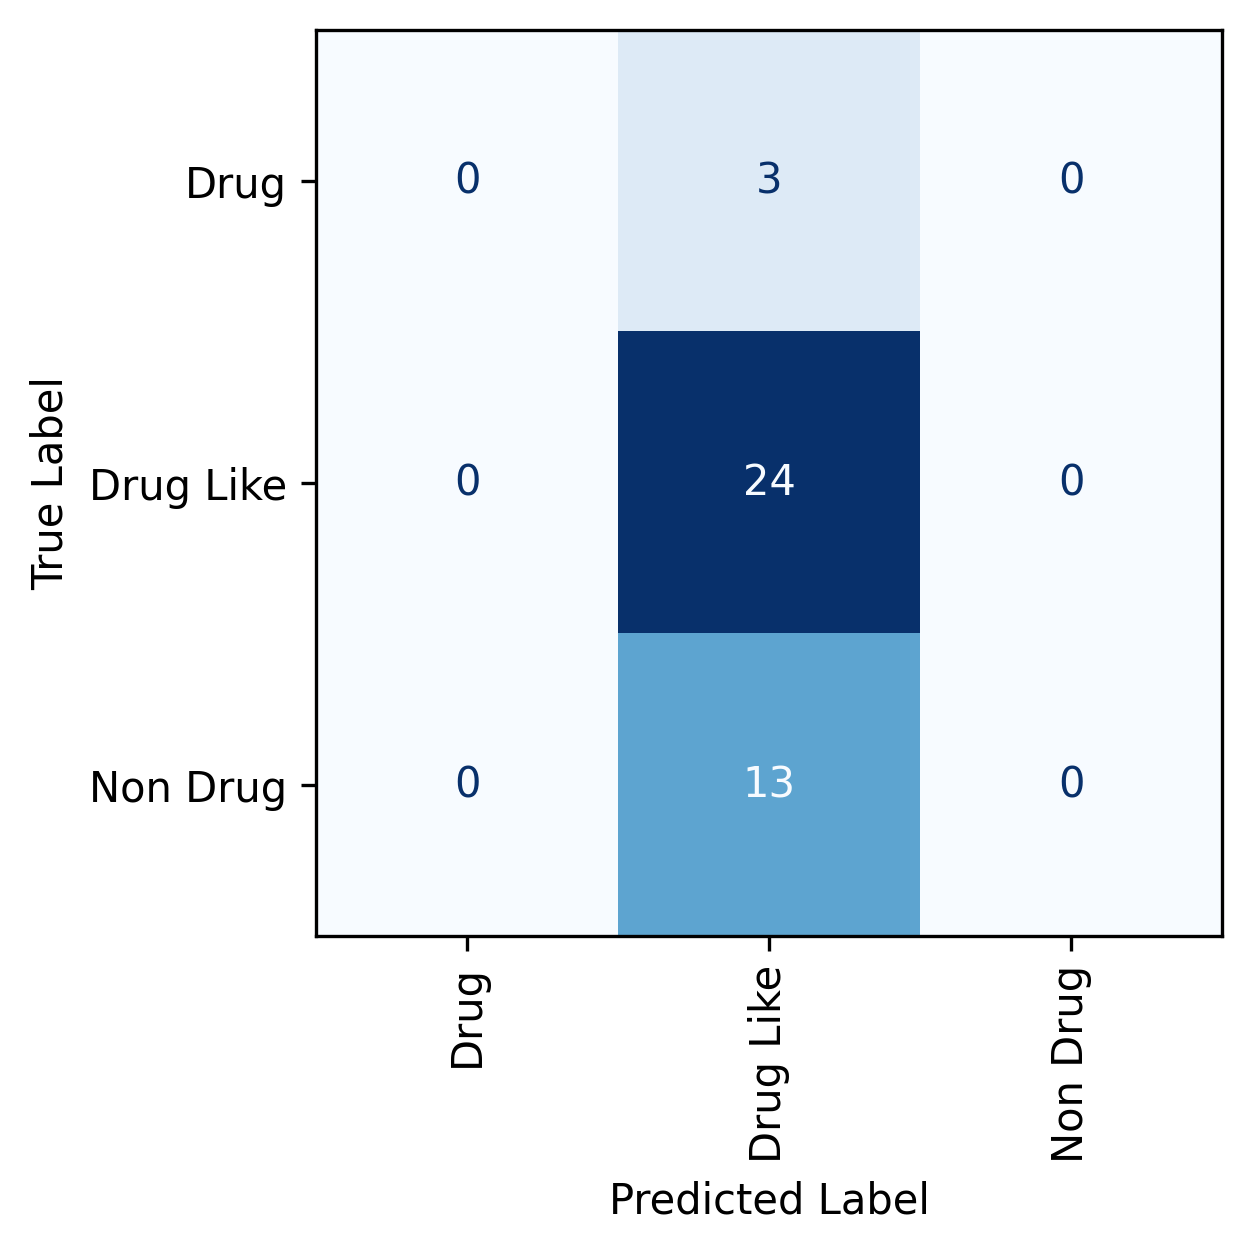

In [40]:
plot_confusion_matrix(labels, pred_labels, classes)

In [41]:
corrects = torch.eq(labels, pred_labels)

In [42]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [43]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x.unsqueeze(1))

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [44]:
outputs, labels = get_representations(model, train_iterator)

In [45]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [46]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(dpi=400)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'viridis')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

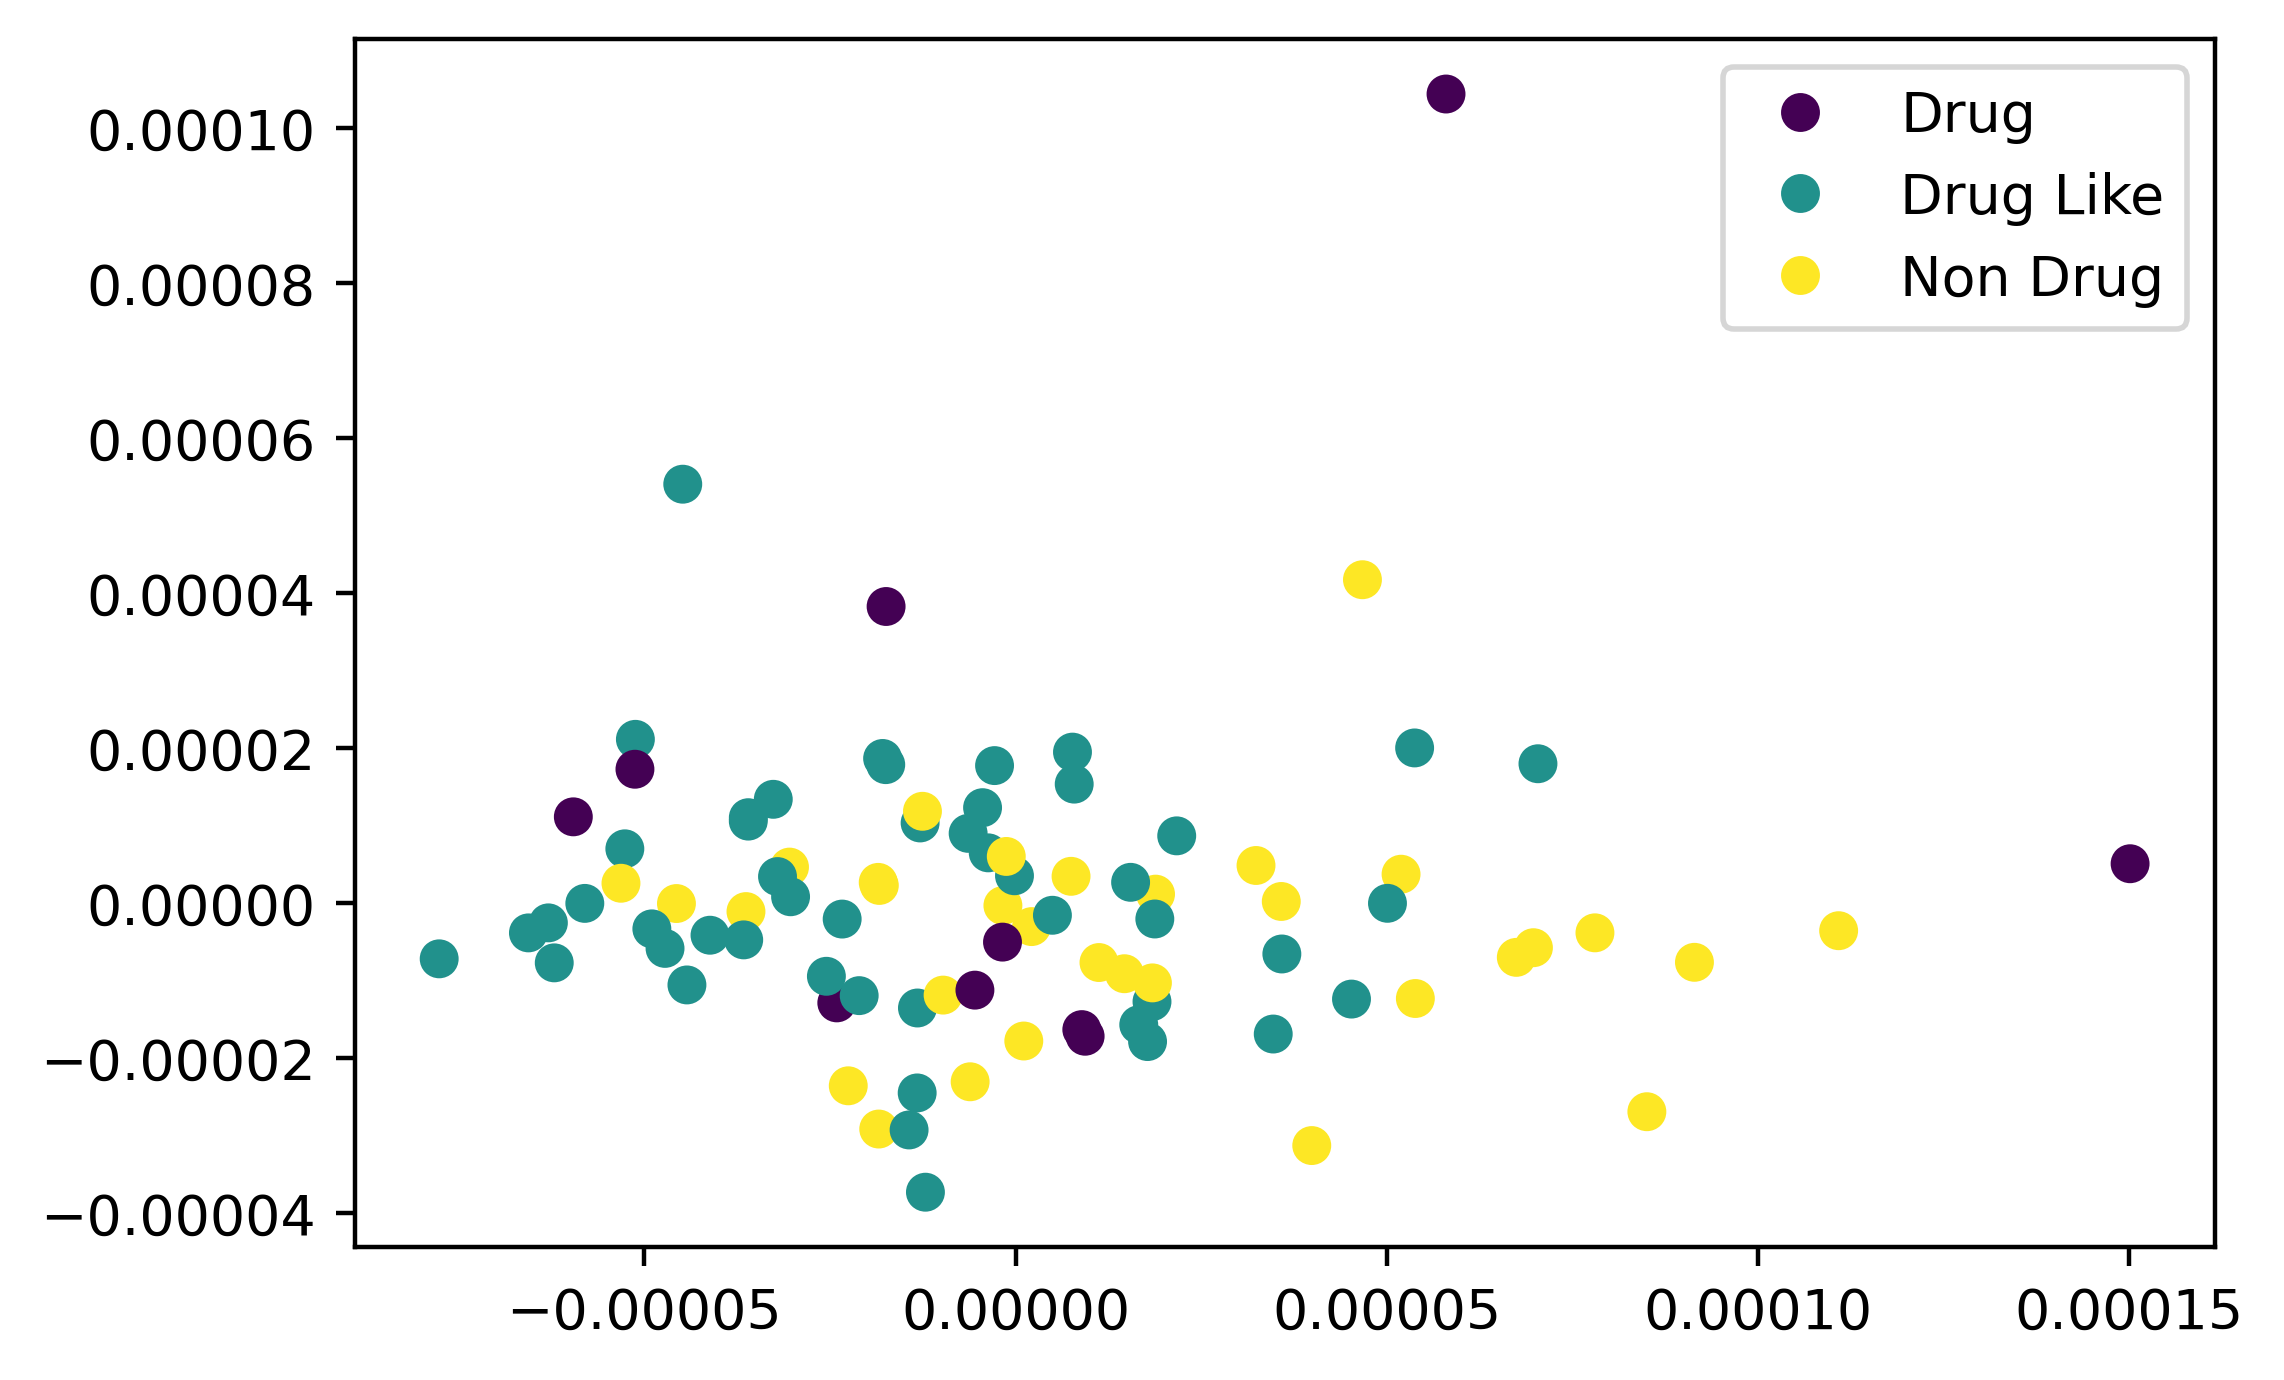

In [47]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [48]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

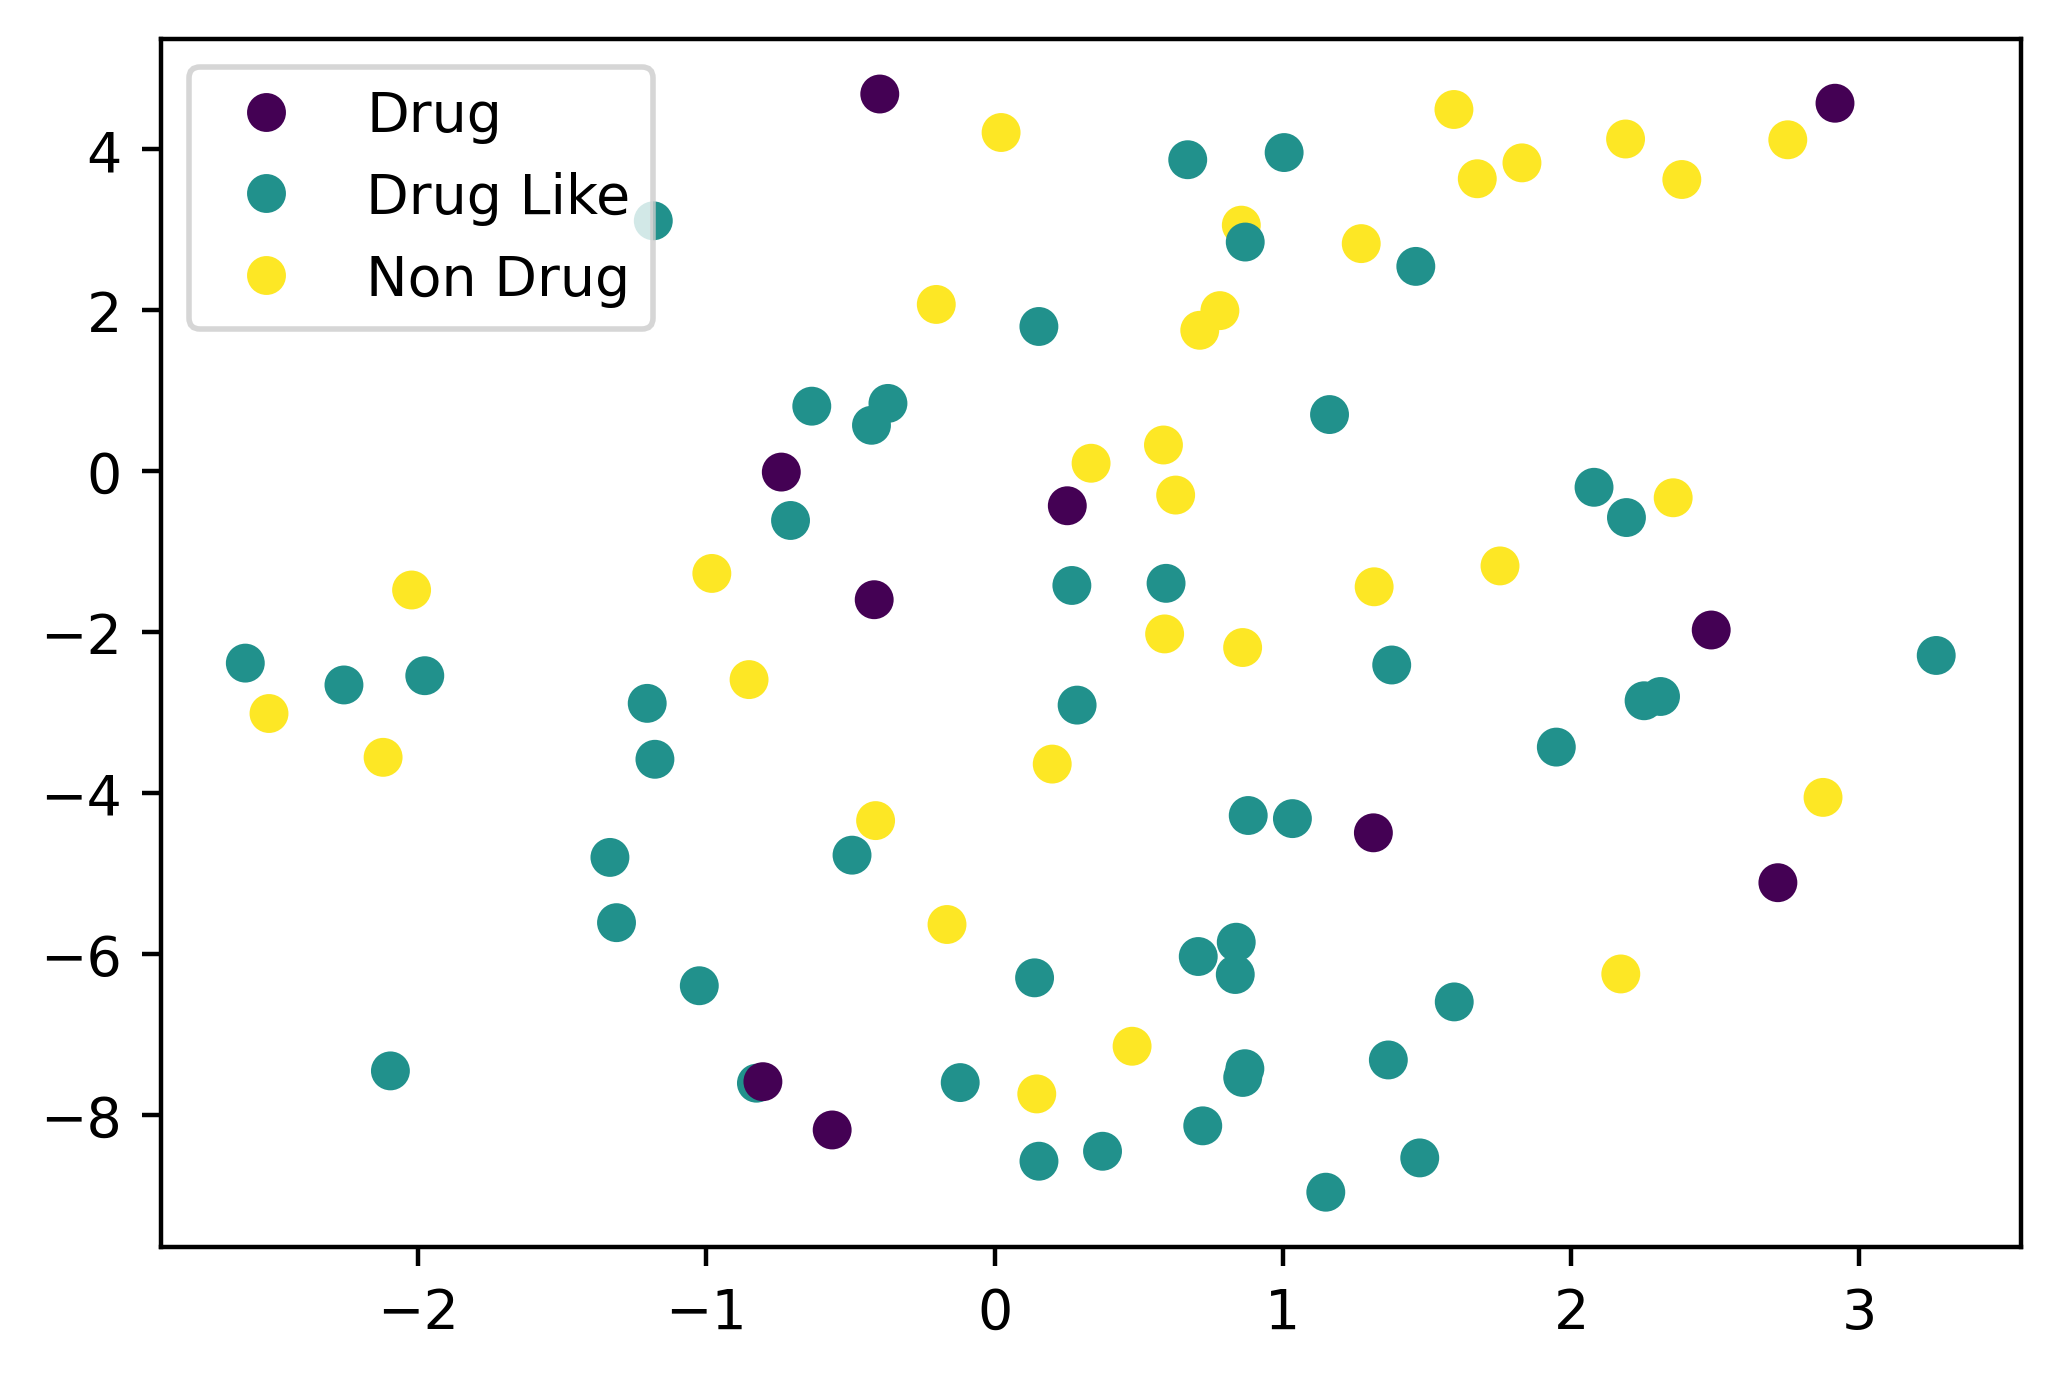

In [49]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)